# Prevendo o preço de aluguel na cidade de São Paulo

* Queremos entender como é a variação do preço dos aluguéis na cidade a partir de uma base de dados [disponível no Kaggle da Imobiliária Quinto Andar](https://www.kaggle.com/datasets/dantebarros/transformed-data-from-quinto-andars-platform)
    - A previsão do aluguel do imóvel resulta em uma decisão de negócio: decidir em quais imóveis investir e quais imóveis trarão um retorno financeiro mais rápido do investimento.

## Etapas do Projeto

1. [Entendimento e tratamento dos dados](#dados)
2. [Análise Exploratória](#eda)
3. [Tratamento dos Dados](#tratamento)
4. [Definição do modelo](#modelo)
5. [Modelo em produção](#producao)

<a id='dados'></a>
## Entendimento e tratamento dos dados

In [1]:
# Importando a biblioteca Pandas para manipulação da base de dados
import pandas as pd

In [2]:
# Importando a base de dados como um DataFrame
base = pd.read_csv('quinto_andar_transformed_data.csv')

# Visualizando as primeiras linhas do DataFrame
base.head(5)

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,https://www.quintoandar.com.br/imovel/89332996...,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,https://www.quintoandar.com.br/imovel/89334069...,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,https://www.quintoandar.com.br/imovel/89333859...,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,https://www.quintoandar.com.br/imovel/89337065...,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,https://www.quintoandar.com.br/imovel/89337700...,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


* Interpretar o que cada atributo/feature/coluna significa para um dado imóvel é importante para definir quais são nossos objetivos de predições e quais são importantes para o modelo final.

* Para validarmos os dados, é importante entender quais são os tipos/classes de dados armazenados no DataFrame:
    - Podemos utilizar o atributo do Pandas .info()

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              2775 non-null   object 
 1   bairro           2775 non-null   object 
 2   aluguel          2775 non-null   float64
 3   condominio       2768 non-null   float64
 4   iptu             2767 non-null   float64
 5   seguro_incendio  2775 non-null   float64
 6   taxa_serviço     2775 non-null   float64
 7   total            2775 non-null   float64
 8   metragem         2775 non-null   float64
 9   quarto           2775 non-null   float64
 10  banheiro         2775 non-null   float64
 11  vaga_carro       2775 non-null   float64
 12  andar            2775 non-null   float64
 13  aceita_pet       2775 non-null   float64
 14  mobilia          2775 non-null   float64
 15  metro_prox       2775 non-null   float64
dtypes: float64(14), object(2)
memory usage: 347.0+ KB


* O que tiramos do .info()?
    - A *url* e *bairro* são do tipo string, a classe de tipo texto que não é possível de colocar para treinarmos modelos de Machine Learning;
    - Features como *condomínio* e *iptu* possuem valores nulos.

In [4]:
# Somando quantos valores nulos existem em cada coluna, lembrando que o método .isnull() retorna um DataFrame de booleanos, por isso a soma retorna True=1 e False=0
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         7
iptu               8
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

In [5]:
# Filtrando os imóveis com condomínio nulo
base[base.condominio.isnull()]

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
987,https://www.quintoandar.com.br/imovel/89288689...,Bela Vista,2960.0,NaN,125.0,49.0,59.0,3193.0,100.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0
1391,https://www.quintoandar.com.br/imovel/89310205...,Perdizes,5200.0,NaN,1030.0,86.0,104.0,6420.0,220.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0
1527,https://www.quintoandar.com.br/imovel/89310896...,Aclimação,3000.0,NaN,158.0,50.0,60.0,3268.0,90.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0
1801,https://www.quintoandar.com.br/imovel/89284189...,Ipiranga,2600.0,NaN,100.0,43.0,52.0,2795.0,100.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
2287,https://www.quintoandar.com.br/imovel/89288795...,Ipiranga,1000.0,NaN,80.0,17.0,20.0,1117.0,25.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0
2387,https://www.quintoandar.com.br/imovel/89288796...,Ipiranga,1375.0,NaN,100.0,23.0,27.0,1525.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2751,https://www.quintoandar.com.br/imovel/89288796...,Ipiranga,1375.0,NaN,100.0,23.0,27.0,1525.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


* Uma possibilidade é acessar o anúncio pela URL e encontrar o valor do condomínio.

In [6]:
base.url[2287]

'https://www.quintoandar.com.br/imovel/892887955?house_tags=rentPriceDecreased&search_rank=%7B%22sortMode%22%3A%22relevance%22%2C%22searchMode%22%3A%22list%22%2C%22resultsOrigin%22%3A%22search%22%2C%22rank%22%3A929%2C%22personalization%22%3Atrue%7D&search_id=%22d29c9fa4f19011eb8c20e2cf81d20c5e%22&from_route=%22search_results%22'

* Analisando os imóveis no site da Quinto Andar, nota-se que em sua maioria, os imóveis que não possuem condomónio são casas e, então, pode-se substituir este atributo por valores nulos

In [7]:
base.loc[base.condominio.isnull(), 'condominio']

987    NaN
1391   NaN
1527   NaN
1801   NaN
2287   NaN
2387   NaN
2751   NaN
Name: condominio, dtype: float64

In [8]:
base.loc[base.condominio.isnull(), 'condominio'] = 0

In [9]:
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         0
iptu               8
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

In [10]:
base[base.iptu.isnull()]

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
321,https://www.quintoandar.com.br/imovel/89278332...,Jardim Paulista,3530.0,1000.0,NaN,45.0,70.0,4723.0,75.0,1.0,2.0,1.0,10.0,1.0,0.0,1.0
580,https://www.quintoandar.com.br/imovel/89276781...,Aclimação,1500.0,477.0,NaN,20.0,30.0,2027.0,67.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
732,https://www.quintoandar.com.br/imovel/89277791...,Vila Olímpia,3700.0,0.0,NaN,47.0,74.0,3821.0,60.0,1.0,1.0,1.0,15.0,0.0,0.0,0.0
1348,https://www.quintoandar.com.br/imovel/89277231...,Consolação,2696.0,1033.0,NaN,35.0,53.0,3882.0,88.0,3.0,2.0,1.0,4.0,1.0,1.0,1.0
1486,https://www.quintoandar.com.br/imovel/89279154...,Jardim Paulista,6750.0,1400.0,NaN,86.0,135.0,8371.0,90.0,1.0,2.0,2.0,4.0,0.0,1.0,1.0
1709,https://www.quintoandar.com.br/imovel/89281155...,Aclimação,3000.0,1100.0,NaN,39.0,60.0,4199.0,100.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0
2209,https://www.quintoandar.com.br/imovel/89278332...,Jardim Paulista,3530.0,1000.0,NaN,45.0,70.0,4723.0,75.0,1.0,2.0,1.0,10.0,1.0,0.0,1.0
2659,https://www.quintoandar.com.br/imovel/89279454...,Bela Vista,906.0,267.0,NaN,12.0,18.0,1203.0,27.0,1.0,1.0,0.0,14.0,0.0,0.0,1.0


* Aqui, podemos tentar encontrar qual é o valor médio do IPTU para estas casas/apartamentos nos bairros em que estão localizados. Mas como temos apenas 8 linhas com IPTU faltante, exclui-las não fará uma grande diferença no modelo preditivo.

In [11]:
base = base.dropna(axis=0) # Removendo linhas com valores nulos

In [12]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2767 entries, 0 to 2774
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              2767 non-null   object 
 1   bairro           2767 non-null   object 
 2   aluguel          2767 non-null   float64
 3   condominio       2767 non-null   float64
 4   iptu             2767 non-null   float64
 5   seguro_incendio  2767 non-null   float64
 6   taxa_serviço     2767 non-null   float64
 7   total            2767 non-null   float64
 8   metragem         2767 non-null   float64
 9   quarto           2767 non-null   float64
 10  banheiro         2767 non-null   float64
 11  vaga_carro       2767 non-null   float64
 12  andar            2767 non-null   float64
 13  aceita_pet       2767 non-null   float64
 14  mobilia          2767 non-null   float64
 15  metro_prox       2767 non-null   float64
dtypes: float64(14), object(2)
memory usage: 367.5+ KB


In [13]:
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         0
iptu               0
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

* Para a análise do modelo, o URL não servirá de nada a partir de agora

In [14]:
base = base.drop('url', axis=1)

In [15]:
base.head(5)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


<a id='eda'></a>
## Análise Exploratória de Dados

* Essa etapa consiste em entender a estatística dos nossos dados para podermos aprofundar a análise.

* Como nossa base de dados está em um DataFrame do Pandas, uma boa possibilidade é utilizar o .describe()

In [16]:
base.describe()

,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
count,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000
mean,2276.430430,596.070473,283.561980,29.923021,45.325985,3232.463679,63.759668,1.593784,1.398265,0.627033,5.924828,0.775208,0.202024,0.733647
std,1327.758115,430.433379,9424.657082,17.660109,26.584522,9600.842536,38.680371,0.748924,0.686907,0.674153,5.000881,0.417521,0.401582,0.442131
min,500.000000,0.000000,0.000000,7.000000,10.000000,697.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1400.000000,330.000000,0.000000,18.000000,28.000000,1876.000000,40.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,1950.000000,520.000000,55.000000,26.000000,39.000000,2615.000000,52.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000
75%,2735.000000,800.000000,140.000000,36.000000,54.000000,3751.000000,76.000000,2.000000,2.000000,1.000000,9.000000,1.000000,0.000000,1.000000
max,11250.000000,3300.000000,495800.000000,187.000000,225.000000,499600.000000,587.000000,5.000000,7.000000,6.000000,43.000000,1.000000,1.000000,1.000000


* Aqui, podemos olhar especialmente para a feature Aluguel:
    - Possui um desvio padrão alto, o que significa que há uma grande dispersão dos valores em relação à média. 
    - A mediana, o segundo quartil (50%), é 1950, enquanto o máximo é 11250. Isso significa que metade dos aluguéis estão abaixo da mediana e a outra metade está dispersa até o valor máximo.

In [17]:
# Contando o número de registros antes e depois da mediana
base[base.aluguel <= base.aluguel.median()].shape[0] # ou base[base.aluguel <= base.aluguel.median()] para mostrar o DataFrame dos registros

1387

In [18]:
base[base.aluguel > base.aluguel.median()].shape[0]

1380

* Nota-se que, o número de registro é praticamente idêntico, porém, a faixa de distribuição de valores acima da mediana é muito alta, o que resulta em um alto desvio padrão.

* Podemos analisar essa distribuição com um Histograma

<Axes: >

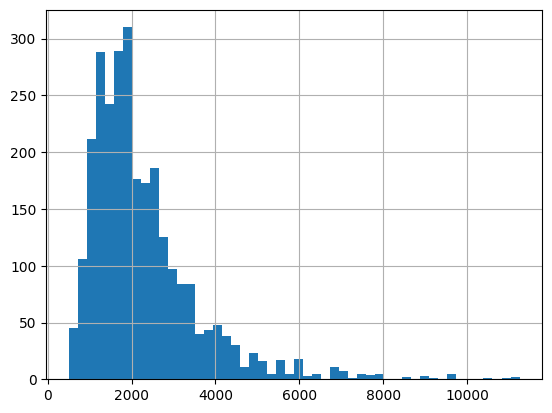

In [19]:
base.aluguel.hist(bins=50)

* Melhorando a visualização dos dados com **Matplotlib**

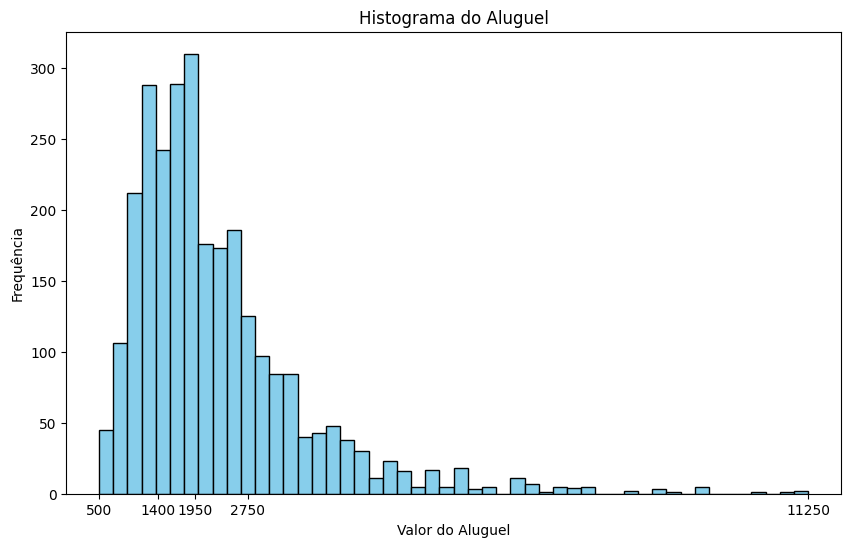

In [20]:
# Plotando o histograma da feature aluguel
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(base.aluguel, bins=50, color='skyblue', edgecolor='black')

ax.set(xlim=(0, base.aluguel.max()+500), xticks=[500, 1400, 1950, 2750, 11250])

plt.title('Histograma do Aluguel')
plt.xlabel('Valor do Aluguel')
plt.ylabel('Frequência')
plt.show()

* Uma outra possibilidade é utilizar o **NumPy** para extrarir a Frequência para cada valor

In [21]:
import numpy as np
np.histogram(base.aluguel, bins=50)

(array([ 45, 106, 212, 288, 242, 289, 310, 176, 173, 186, 125,  97,  84,
         84,  40,  43,  48,  38,  30,  11,  23,  16,   5,  17,   5,  18,
          3,   5,   0,  11,   7,   1,   5,   4,   5,   0,   0,   2,   0,
          3,   1,   0,   5,   0,   0,   0,   1,   0,   1,   2], dtype=int64),
 array([  500.,   715.,   930.,  1145.,  1360.,  1575.,  1790.,  2005.,
         2220.,  2435.,  2650.,  2865.,  3080.,  3295.,  3510.,  3725.,
         3940.,  4155.,  4370.,  4585.,  4800.,  5015.,  5230.,  5445.,
         5660.,  5875.,  6090.,  6305.,  6520.,  6735.,  6950.,  7165.,
         7380.,  7595.,  7810.,  8025.,  8240.,  8455.,  8670.,  8885.,
         9100.,  9315.,  9530.,  9745.,  9960., 10175., 10390., 10605.,
        10820., 11035., 11250.]))

* Uma outra ferramenta importante para entender a estatística dos dados é utilizar o boxplot. Com essa ferramenta, podemos visualizar como os *outliers* podem influenciar na estatística do nosso modelo

<Axes: >

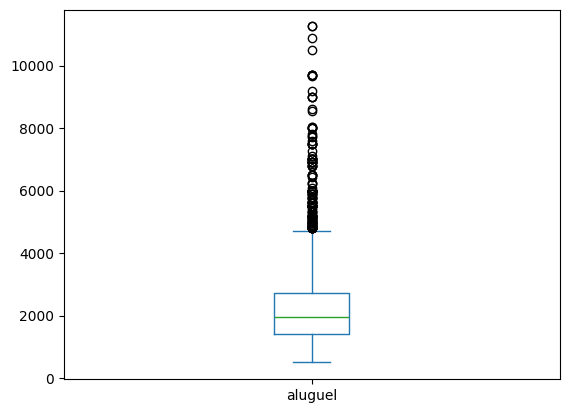

In [22]:
base.aluguel.plot.box()

* A dispersão dos dados após o quarto quartil mostra que há muitos dados como possíveis outliers, o que pode tornar nosso modelo preditivo instável.

* Entender o *por quê* estes imóveis possuem aluguéis mais caros pode ser uma boa forma de entender a estrutura dos dados e quais features aumentam o aluguel.

In [23]:
base.sort_values(by='aluguel', ascending=False).head(10)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
235,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
2305,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
1581,Jardim Paulista,10870.0,2008.0,575.0,138.0,217.0,13810.0,190.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0
762,Paraíso,10500.0,2425.0,42.0,134.0,210.0,13310.0,200.0,3.0,5.0,2.0,8.0,1.0,1.0,1.0
2723,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
1402,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
255,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
2311,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
1629,Jardim Paulista,9660.0,1300.0,333.0,123.0,193.0,11610.0,130.0,2.0,2.0,1.0,5.0,1.0,0.0,1.0
387,Itaim Bibi,9200.0,2380.0,694.0,117.0,184.0,12580.0,210.0,4.0,4.0,2.0,11.0,1.0,0.0,0.0


* Existem muitos valores duplicados na base de dados

In [24]:
base[base.duplicated()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
77,Barra Funda,1060.0,287.0,0.0,14.0,21.0,1382.0,50.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
176,Belém,1200.0,200.0,20.0,20.0,24.0,1464.0,30.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
250,Belém,1200.0,200.0,20.0,20.0,24.0,1464.0,30.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
267,Paraíso,3400.0,1372.0,360.0,44.0,68.0,5244.0,147.0,3.0,3.0,1.0,4.0,1.0,0.0,1.0
306,Perdizes,2150.0,0.0,0.0,28.0,43.0,2221.0,72.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,Vila Nova Conceição,3090.0,900.0,184.0,40.0,61.0,4275.0,85.0,2.0,2.0,1.0,12.0,1.0,0.0,0.0
2770,Aclimação,2200.0,0.0,72.0,37.0,44.0,2353.0,90.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0
2771,Santa Cecília,1120.0,280.0,0.0,15.0,22.0,1437.0,32.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0
2773,Aclimação,1100.0,308.0,16.0,14.0,22.0,1460.0,30.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0


In [25]:
base = base.drop_duplicates(keep='last')

In [26]:
base.sort_values(by='aluguel', ascending=False).head(10)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
2305,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
1581,Jardim Paulista,10870.0,2008.0,575.0,138.0,217.0,13810.0,190.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0
762,Paraíso,10500.0,2425.0,42.0,134.0,210.0,13310.0,200.0,3.0,5.0,2.0,8.0,1.0,1.0,1.0
2723,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
2311,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
1629,Jardim Paulista,9660.0,1300.0,333.0,123.0,193.0,11610.0,130.0,2.0,2.0,1.0,5.0,1.0,0.0,1.0
387,Itaim Bibi,9200.0,2380.0,694.0,117.0,184.0,12580.0,210.0,4.0,4.0,2.0,11.0,1.0,0.0,0.0
1505,Jardim Paulista,9000.0,2480.0,496.0,115.0,180.0,12270.0,160.0,3.0,4.0,1.0,7.0,1.0,0.0,1.0
2047,Vila Olímpia,8999.0,2300.0,616.0,115.0,179.0,12210.0,128.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0
680,Jardim Paulista,8990.0,1362.0,352.0,114.0,179.0,11000.0,140.0,2.0,3.0,1.0,19.0,1.0,0.0,1.0


In [27]:
# Comprovando que os registros duplicados foram removidos
base.shape

(2117, 15)

* Agora que os registros duplicados foram removidos, podemos entender a correlação entre a feature aluguel e as demais features que podem resultar no aumento dele

<Axes: xlabel='metragem', ylabel='aluguel'>

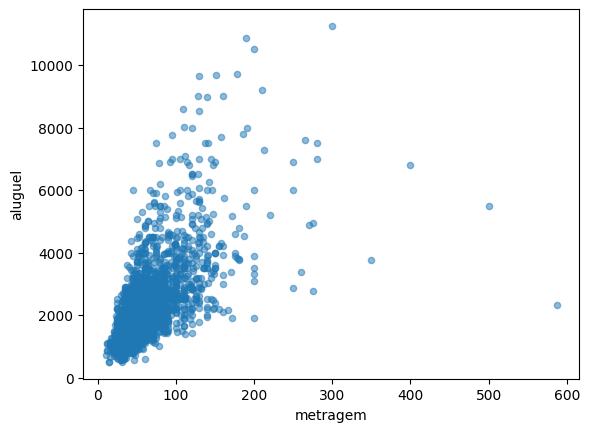

In [28]:
# Qual a relação entre metragem e aluguel?
base.plot.scatter(x='metragem', y='aluguel', alpha=0.5)

<Axes: xlabel='quarto', ylabel='aluguel'>

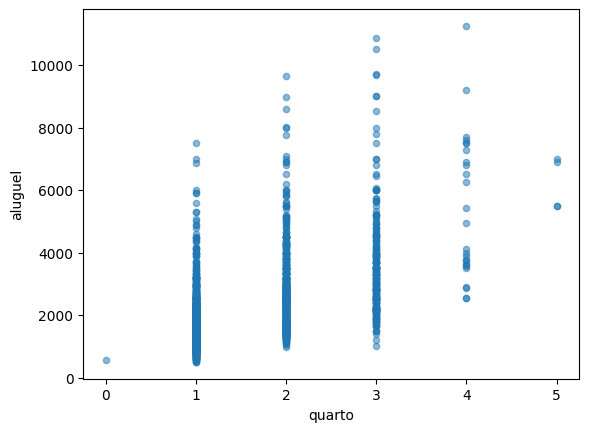

In [29]:
# Relação entre quantidade de quartos e aluguel
base.plot.scatter(x='quarto', y='aluguel', alpha=0.5)

* Podemos perceber que o aumento da metragem influencia no valor do aluguel, mas não é uma relação linear obrigatória. 

* O número de quartos não influencia tanto no valor do aluguel.

* Uma ótima ferramenta de visualização de dispersões e correlações é o **Seaborn**

In [30]:
# Importando o Seaborn
import seaborn as sns

<Axes: xlabel='metro_prox', ylabel='aluguel'>

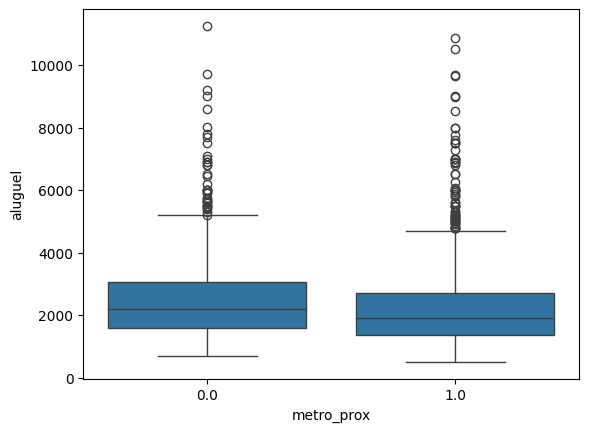

In [31]:
sns.boxplot(x='metro_prox', y='aluguel', data=base)

<Axes: xlabel='aluguel', ylabel='bairro'>

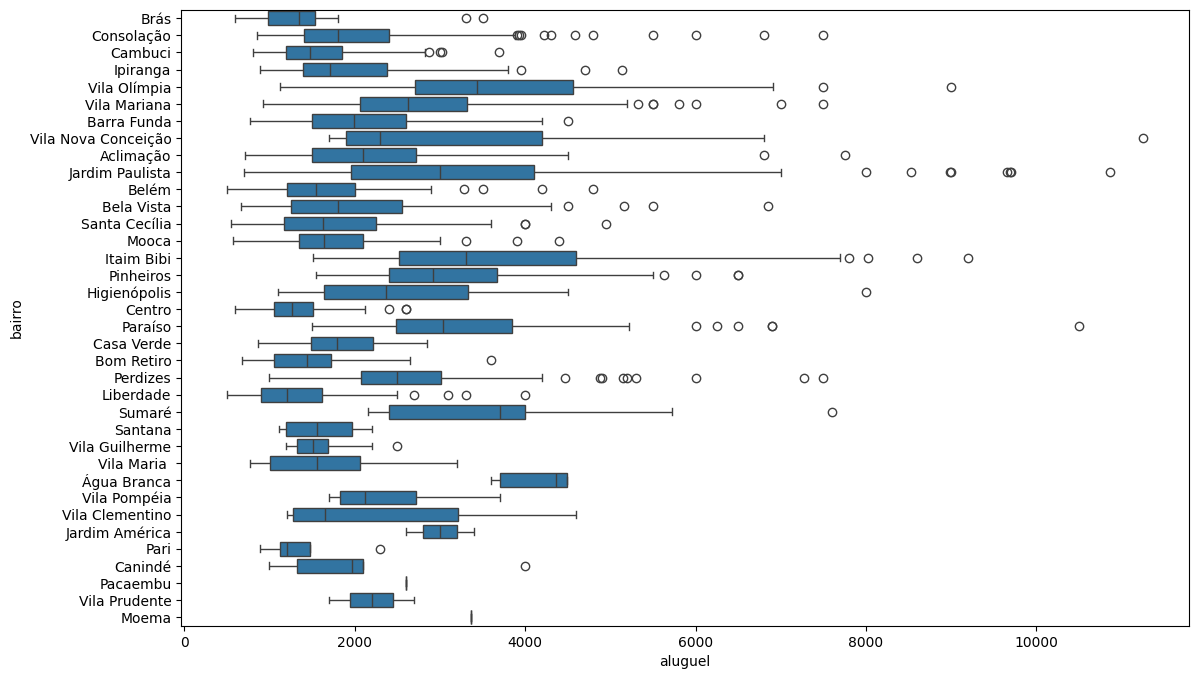

In [32]:
# Relação entre bairro e aluguel
fig, ax = plt.subplots(figsize=(13, 8))

sns.boxplot(x='aluguel', y='bairro', data=base, orient='h')

* Alguns bairros como Vila Olímpia, Itaim Bibi, Jardim Paulista, possuem aluguéis acima da média. Essa dispersão nos da ideia de que, se tiverem um baixo valor de compra, será um bom investimento com alto retorno mensal, já que o aluguel será alto.

In [33]:
base.bairro.value_counts()

bairro
Consolação             271
Jardim Paulista        190
Bela Vista             187
Santa Cecília          178
Pinheiros              117
Vila Mariana           114
Mooca                   99
Itaim Bibi              87
Cambuci                 86
Liberdade               86
Perdizes                84
Centro                  80
Aclimação               75
Paraíso                 59
Ipiranga                55
Barra Funda             53
Bom Retiro              51
Belém                   35
Brás                    29
Vila Olímpia            29
Higienópolis            28
Casa Verde              24
Vila Guilherme          18
Vila Nova Conceição     14
Vila Pompéia            14
Vila Clementino         10
Sumaré                   9
Santana                  8
Canindé                  6
Vila Maria               6
Água Branca              5
Pari                     4
Jardim América           2
Vila Prudente            2
Pacaembu                 1
Moema                    1
Name: count, dtype: i

* Nota-se que, temos diversos Bairros disponível na nossa base de dados, com Bairros aparecem poucas vezes, o que pode gerar problemas no modelo de predição. 

* É possível agrupar Bairros por Regiões, como na base 'bairros.xlsx'

In [34]:
# Importando a base de dados de bairros por região
regioes = pd.read_excel('bairros.xlsx')

In [35]:
# Unindo as bases de dados com merge
base2 = pd.merge(base, regioes, how='left', left_on='bairro', right_on='Bairro')

In [36]:
base2.head(3)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
0,Brás,600.0,450.0,14.0,8.0,12.0,1084.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Brás,Leste
1,Consolação,1790.0,598.0,10.0,23.0,35.0,2456.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Consolação,Centro
2,Cambuci,1550.0,1.0,28.0,26.0,31.0,1636.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Cambuci,Centro


* Analisando essa nova base de dados

In [37]:
base2[base2.Região.isnull()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
234,Vila Maria,3200.0,680.0,68.0,41.0,64.0,4053.0,80.0,2.0,2.0,1.0,7.0,1.0,0.0,0.0,NaN,NaN
820,Vila Maria,850.0,0.0,42.0,15.0,17.0,924.0,40.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
1262,Vila Maria,1460.0,220.0,106.0,19.0,29.0,1834.0,70.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN
1684,Vila Maria,2200.0,653.0,172.0,28.0,44.0,3097.0,79.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN
1845,Vila Maria,1657.0,1050.0,291.0,21.0,33.0,3052.0,110.0,2.0,3.0,2.0,4.0,1.0,0.0,0.0,NaN,NaN
2227,Vila Maria,772.0,0.0,100.0,13.0,15.0,900.0,45.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN


In [38]:
regioes[regioes.Bairro == 'Vila Maria']

,Bairro,Região
58,Vila Maria,Norte


In [39]:
base2.loc[base2.Região.isnull(), 'bairro']

234     Vila Maria 
820     Vila Maria 
1262    Vila Maria 
1684    Vila Maria 
1845    Vila Maria 
2227    Vila Maria 
Name: bairro, dtype: object

* A coluna *bairro* da primeira base de dados importada possui um erro de digitação e, portanto, ao concatenar com a nova base de dados das regiões dos bairros, trouxe dados faltantes (NaN)

* Como o bairro Vila Maria se encontra na região norte, uma maneira de realizar o tratamento dos dados é aplicar a região em que aparecem valores nulos como 'Norte' e o nome do Bairro.

In [40]:
base2.loc[base2.Região.isnull(), 'Região'] = 'Norte'

In [41]:
base2.loc[base2.bairro == 'Vila Maria ', 'bairro'] = 'Vila Maria'

In [42]:
base2[base2.Região.isnull()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região


<Axes: xlabel='aluguel', ylabel='Região'>

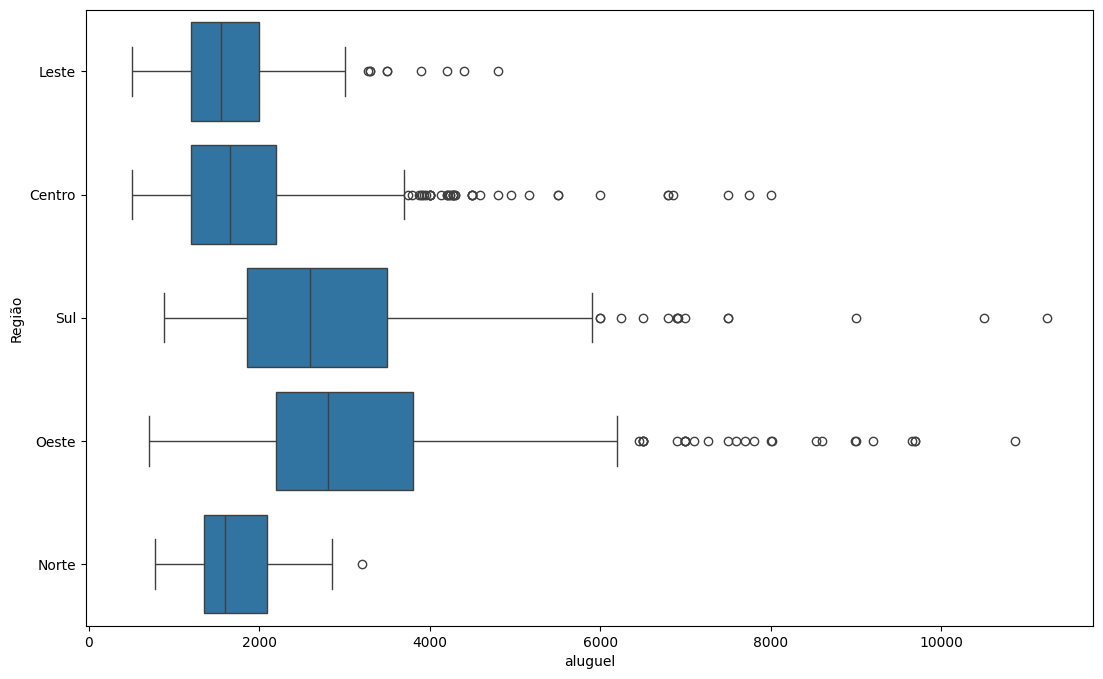

In [43]:
# Agora podemos analisar o gráfico de Aluguel por Região
fig, ax = plt.subplots(figsize=(13, 8))

sns.boxplot(x='aluguel', y='Região', data=base2, orient='h')

* Percebe-se que o aluguel nas regiões Oeste e Sul são os mais caros.

<Axes: xlabel='metragem', ylabel='aluguel'>

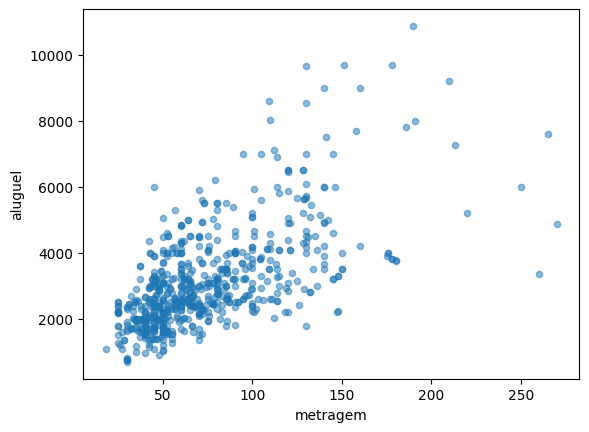

In [44]:
# Relação entre o aluguel e a metragem para imóveis na Região Oeste
base2[base2.Região == 'Oeste'].plot.scatter(x='metragem', y='aluguel', alpha=0.5)

<Axes: xlabel='metragem', ylabel='aluguel'>

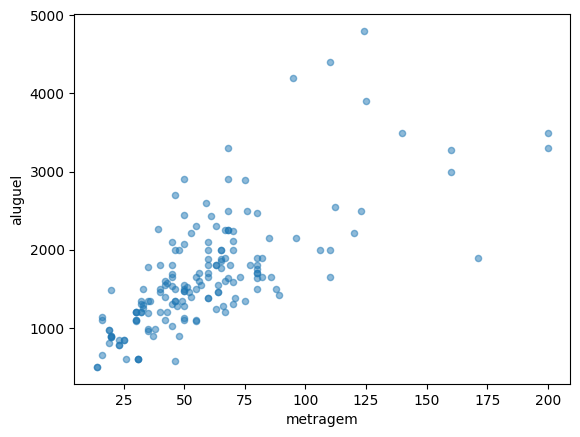

In [45]:
# Relação entre o aluguel e a metragem para imóveis na Região Leste
base2[base2.Região == 'Leste'].plot.scatter(x='metragem', y='aluguel', alpha=0.5)

* Podemos generalizar e analisar como o aluguel de cada região depende da metragem

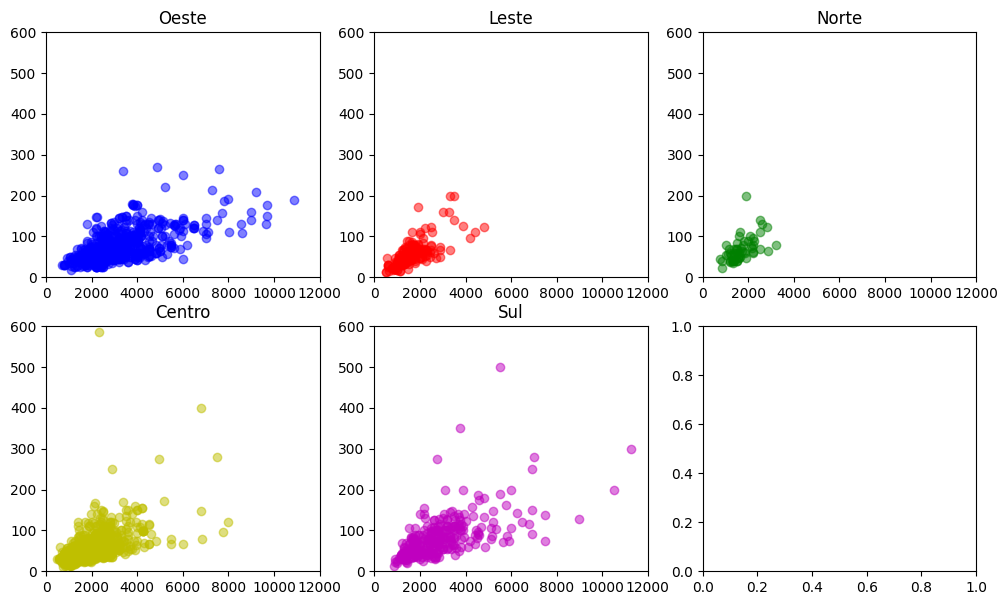

In [46]:
# Para cada região, um gráfico de dispersão aluguel x metragem
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(12,7))

oeste = base2[base2.Região == 'Oeste']
leste = base2[base2.Região == 'Leste']
norte = base2[base2.Região == 'Norte']
centro = base2[base2.Região == 'Centro']
sul = base2[base2.Região == 'Sul']

ax[0,0].scatter(oeste.aluguel, oeste.metragem, c='b',alpha=0.5,label='Oeste')
ax[0,1].scatter(leste.aluguel, leste.metragem, c='r',alpha=0.5,label='Leste')
ax[0,2].scatter(norte.aluguel, norte.metragem, c='g',alpha=0.5,label='Norte')
ax[1,0].scatter(centro.aluguel, centro.metragem, c='y',alpha=0.5,label='Centro')
ax[1,1].scatter(sul.aluguel, sul.metragem, c='m',alpha=0.5,label='Sul')

ax[0,0].set(xlim=(0, 12000),ylim=(0, 600))
ax[0,1].set(xlim=(0, 12000),ylim=(0, 600))
ax[0,2].set(xlim=(0, 12000),ylim=(0, 600))
ax[1,0].set(xlim=(0, 12000),ylim=(0, 600))
ax[1,1].set(xlim=(0, 12000),ylim=(0, 600))

ax[0,0].set_title('Oeste')
ax[0,1].set_title('Leste')
ax[0,2].set_title('Norte')
ax[1,0].set_title('Centro')
ax[1,1].set_title('Sul')

plt.show()


* A partir desta dispersão para cada região podemos encontrar algumas ideias:
    - As regiões Oeste e Sul possuem um valor de aluguel maior para o metro quadrado.
    - A metragem não influencia tanto no valor do aluguel, mas sim a região.

* Qual é a correlação entre essas variáveis?
    - a correção de Pearson do Pandas (.corr()) só considera valores do tipo float, portanto precisamos retirar as features do tipo string.

In [47]:
base2.drop(['bairro', 'Bairro', 'Região'], axis=1).corr()

,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
aluguel,1.000000,0.547477,0.028619,0.986592,0.999937,0.180066,0.625594,0.536307,0.645005,0.566189,0.117477,0.090506,0.195236,-0.107808
condominio,0.547477,1.000000,-0.022161,0.478443,0.547217,0.089427,0.410019,0.414734,0.523017,0.566976,0.242036,0.064668,0.115346,0.000910
iptu,0.028619,-0.022161,1.000000,0.043838,0.028759,0.987828,0.054086,0.073957,0.056725,-0.011616,-0.025528,0.012266,-0.010007,0.010633
seguro_incendio,0.986592,0.478443,0.043838,1.000000,0.986566,0.190569,0.662295,0.551111,0.642922,0.559802,0.072388,0.092343,0.181506,-0.122333
taxa_serviço,0.999937,0.547217,0.028759,0.986566,1.000000,0.180184,0.625697,0.536624,0.644766,0.566322,0.117122,0.091285,0.194803,-0.108255
total,0.180066,0.089427,0.987828,0.190569,0.180184,1.000000,0.151059,0.159203,0.160734,0.085004,-0.000086,0.026351,0.020175,-0.003480
metragem,0.625594,0.410019,0.054086,0.662295,0.625697,0.151059,1.000000,0.725122,0.665260,0.448426,-0.060388,0.139389,-0.054571,-0.152064
quarto,0.536307,0.414734,0.073957,0.551111,0.536624,0.159203,0.725122,1.000000,0.663906,0.445602,-0.021817,0.119335,-0.100762,-0.200685
banheiro,0.645005,0.523017,0.056725,0.642922,0.644766,0.160734,0.665260,0.663906,1.000000,0.516650,0.044936,0.070850,-0.014080,-0.142516
vaga_carro,0.566189,0.566976,-0.011616,0.559802,0.566322,0.085004,0.448426,0.445602,0.516650,1.000000,0.193923,0.064124,0.111359,-0.144232


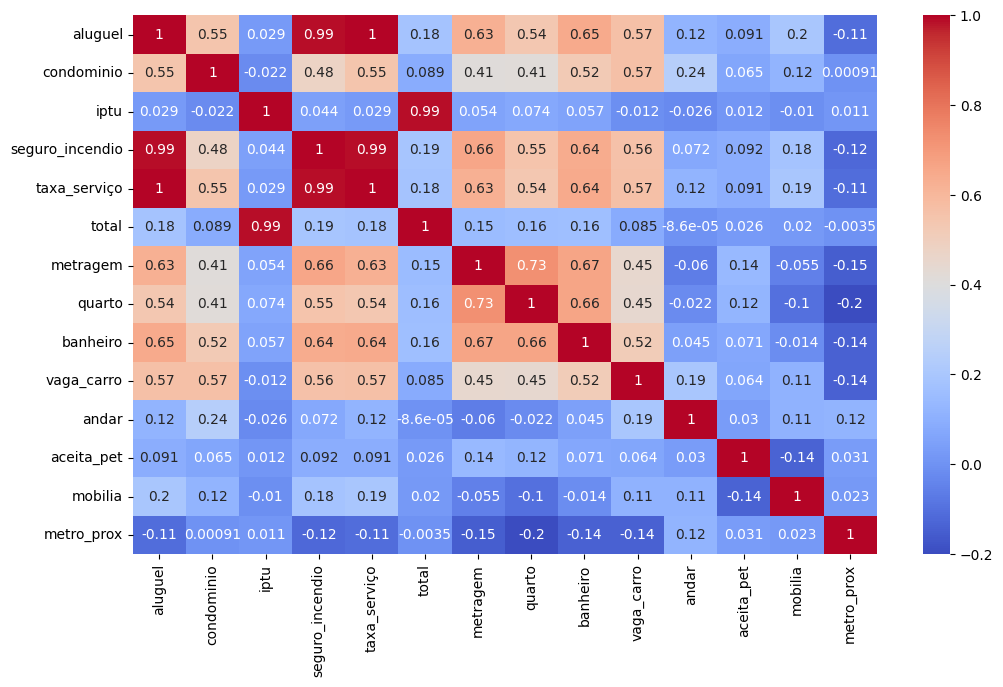

In [48]:
# Mostrando a correlação entre as variáveis numéricas pelo heatmap do Seaborn
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(base2.drop(['bairro', 'Bairro', 'Região'], axis=1).corr(), annot=True, cmap='coolwarm', ax=ax)
plt.show()

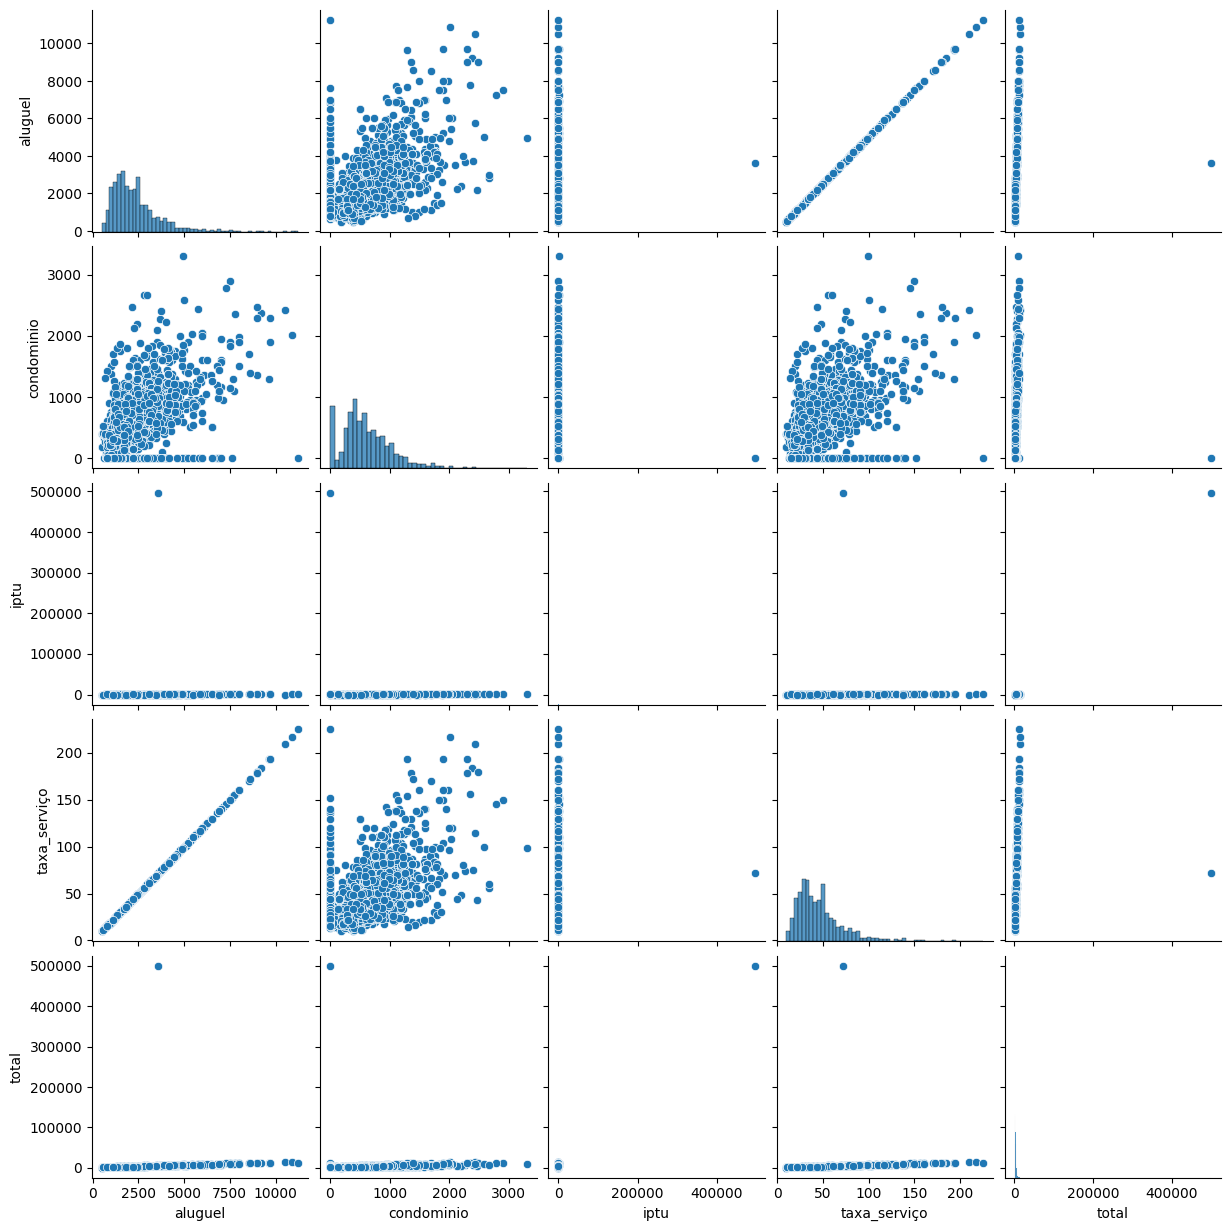

In [49]:
base3 = base2[['aluguel', 'condominio', 'iptu', 'taxa_serviço', 'total']]
sns.pairplot(base3)

* Observações destas relações:
    - Muitos imóveis possuem condominío e iptu inclusos no valor do aluguel;
    - A taxa de serviço aumenta linearmente com o aluguel, o que mostra ser uma porcentagem do valor;
    - Há um outlier

In [50]:
# Verificando o outlier
base2.total.max()

499600.0

In [51]:
base2[base2.total == base2.total.max()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
1188,Santa Cecília,3600.0,0.0,495800.0,60.0,72.0,499600.0,150.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0,Santa Cecília,Centro


* Como o valor do IPTU está totalmente desproporcional, o melhor a fazer é acessar o dado disponível e verificar

In [52]:
verificar = pd.read_csv('quinto_andar_transformed_data.csv')

In [53]:
verificar[verificar.iptu == verificar.iptu.max()]

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
1707,https://www.quintoandar.com.br/imovel/89337922...,Santa Cecília,3600.0,0.0,495800.0,60.0,72.0,499600.0,150.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0


In [54]:
verificar.url[1707]

'https://www.quintoandar.com.br/imovel/893379229?house_tags=newAd&search_rank=%7B%22sortMode%22%3A%22relevance%22%2C%22searchMode%22%3A%22list%22%2C%22resultsOrigin%22%3A%22search%22%2C%22rank%22%3A2561%2C%22personalization%22%3Atrue%7D&search_id=%224bf69054f19a11eb87180a0adc3b16b0%22&from_route=%22search_results%22'

In [55]:
base2.loc[base2.total == base2.total.max(), 'iptu'] = 495.8

In [56]:
base2.loc[base2.iptu == 495.8]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
1188,Santa Cecília,3600.0,0.0,495.8,60.0,72.0,499600.0,150.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0,Santa Cecília,Centro


In [57]:
3600+0+495.8+60+72

4227.8

In [58]:
base2.loc[base2.total == base2.total.max(), 'total'] = 4227.8

* Agora que realizamos o tratamento do outlier, podemos encontrar as correlações novamente

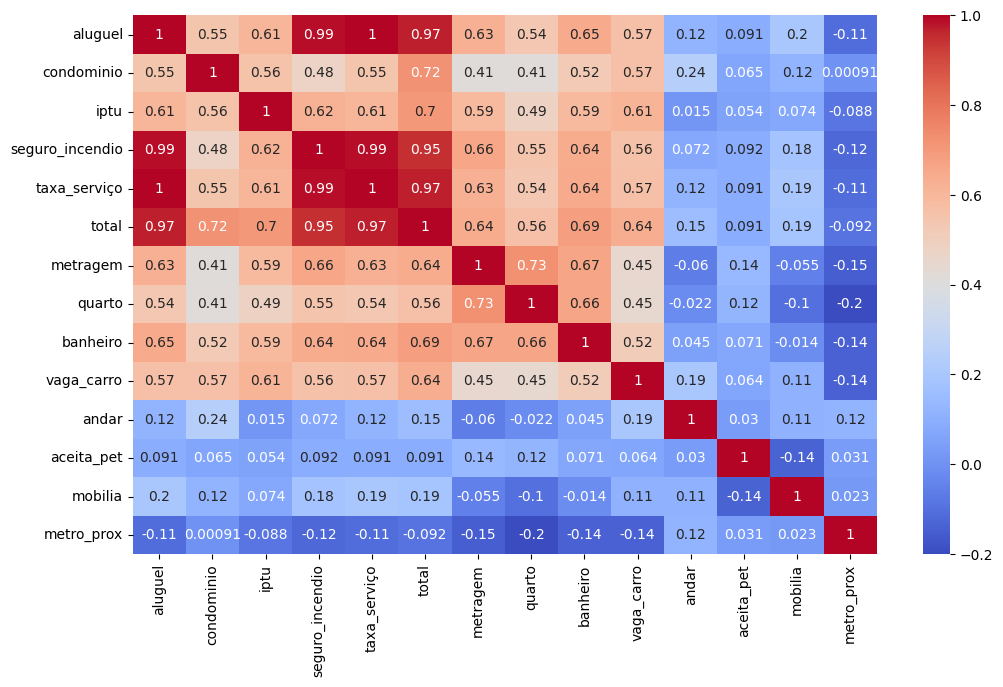

In [59]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(base2.drop(['bairro', 'Bairro', 'Região'], axis=1).corr(), annot=True, cmap='coolwarm', ax=ax)
plt.show()

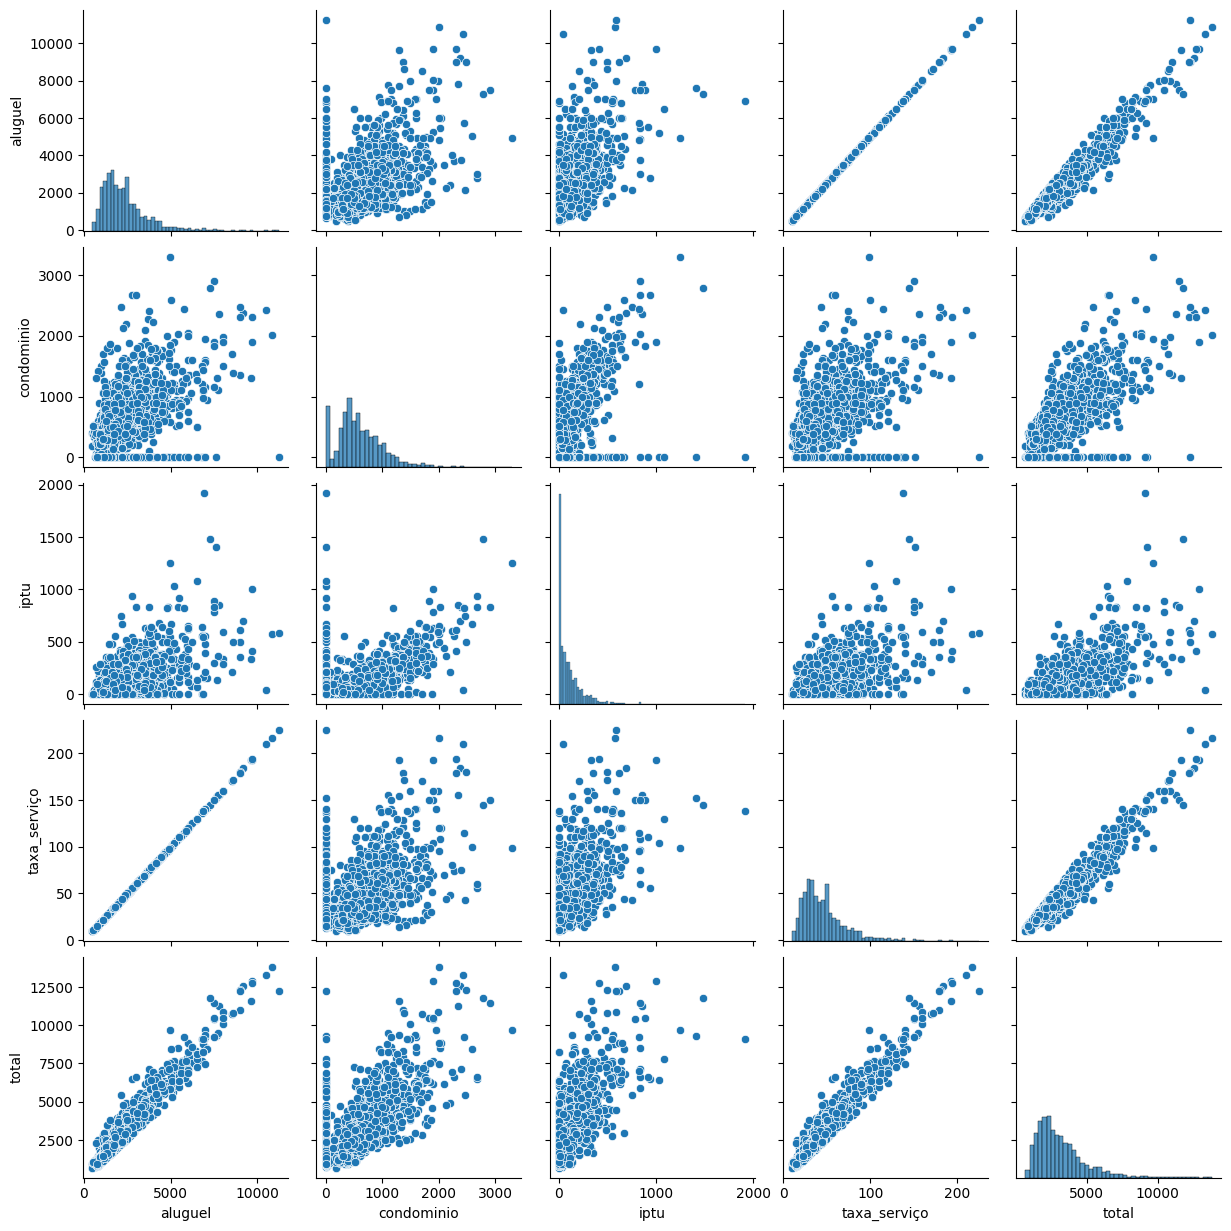

In [60]:
base3 = base2[['aluguel', 'condominio', 'iptu', 'taxa_serviço', 'total']]
sns.pairplot(base3)

* Após tratarmos o outlier, a dispersão dos dados alterou:
    - A correlação entre o valor total e aluguel+condominio+iptu era baixa na primeira situação, com o outlier, mas agora mostra uma forte relação, já que o valor total é a soma dos demais;
    - Os gráficos de dispersão entre as variáveis mostram relações mais diretas sem o outlier.

<a id='tratamento'></a>
## Tratamento dos dados

In [61]:
# Viasulizando a base após toda a análise e tratamento dos dados
base2.head(5)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
0,Brás,600.0,450.0,14.0,8.0,12.0,1084.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Brás,Leste
1,Consolação,1790.0,598.0,10.0,23.0,35.0,2456.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Consolação,Centro
2,Cambuci,1550.0,1.0,28.0,26.0,31.0,1636.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Cambuci,Centro
3,Ipiranga,1600.0,0.0,142.0,27.0,32.0,1801.0,50.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,Ipiranga,Sul
4,Vila Olímpia,1700.0,1106.0,218.0,22.0,34.0,3080.0,74.0,2.0,2.0,1.0,11.0,1.0,0.0,0.0,Vila Olímpia,Sul


* Tentando encontrar a relação entre a *taxa de serviço* e o *valor do aluguel*

In [62]:
# Salvando a taxa de serviço em porcentagem em relação ao valor do aluguel
base2['taxa_porc'] = round((base2.taxa_serviço/base2.aluguel)*100,2)

In [63]:
base2.taxa_porc.value_counts()

taxa_porc
2.00    1374
1.99     206
1.98     203
1.96     130
1.97     129
1.95      49
1.93      48
1.94      45
1.92      19
1.91      10
1.90       9
1.88       5
2.01       2
2.02       2
2.07       1
1.89       1
2.03       1
Name: count, dtype: int64

In [64]:
# Verificando a relação entre o seguro_incendio e o aluguel
base2['taxa_inc'] = round((base2.seguro_incendio/base2.aluguel)*100,2)

In [65]:
base2.taxa_inc.value_counts()

taxa_inc
1.28    435
1.29    434
1.27    426
1.30    290
1.31    197
1.33    147
1.32     84
1.34     37
1.67     32
1.68     29
1.35     15
1.66     15
1.37     15
1.36     14
1.69     11
1.70     11
1.38     10
1.65      6
1.39      4
1.71      4
1.41      4
1.75      3
1.40      3
1.74      1
1.76      1
0.66      1
0.29      1
1.85      1
1.23      1
0.48      1
1.43      1
Name: count, dtype: int64

* Note que, a taxa de serviço e a taxa de incêndio são porcentagens em relação ao valor do aluguel.

* O valor Total também depende da soma destes valores, ou seja, não são boas features para prever qual deve ser o valor do aluguel.

In [66]:
base2 = base2.drop(['taxa_serviço', 'seguro_incendio', 'taxa_porc', 'taxa_inc'], axis=1)

In [67]:
base2.head(3)

,bairro,aluguel,condominio,iptu,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
0,Brás,600.0,450.0,14.0,1084.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Brás,Leste
1,Consolação,1790.0,598.0,10.0,2456.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Consolação,Centro
2,Cambuci,1550.0,1.0,28.0,1636.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Cambuci,Centro


In [68]:
# Relação entre IPTU e aluguel
base2['taxa_iptu'] = round((base2.iptu/base2.aluguel),2)

In [69]:
base2.taxa_iptu.value_counts()

taxa_iptu
0.00    671
0.03    228
0.04    189
0.05    184
0.06    175
0.02    172
0.07    127
0.01    115
0.08     82
0.09     65
0.10     55
0.11     31
0.12     25
0.13     23
0.14     16
0.18     13
0.15     12
0.17     12
0.16      9
0.20      5
0.19      5
0.28      4
0.23      2
0.26      2
0.30      2
0.31      2
0.21      1
0.24      1
0.25      1
0.34      1
0.22      1
0.33      1
0.35      1
0.36      1
Name: count, dtype: int64

* O valor do IPTU depende do bairro, tamanho do apartamento e características do imóvel. Logo, podemos manter essa taxa para realizar a predição e, futuramente, realizar o teste sem ele.

In [70]:
base2 = base2.drop('taxa_iptu', axis=1)

In [71]:
base2 = base2.drop('total', axis=1)

In [72]:
base2.head(3)

,bairro,aluguel,condominio,iptu,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
0,Brás,600.0,450.0,14.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Brás,Leste
1,Consolação,1790.0,598.0,10.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Consolação,Centro
2,Cambuci,1550.0,1.0,28.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Cambuci,Centro


In [73]:
base2 = base2.drop(['bairro', 'Bairro'], axis=1)

In [74]:
base2.head(3)

,aluguel,condominio,iptu,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Região
0,600.0,450.0,14.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Leste
1,1790.0,598.0,10.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Centro
2,1550.0,1.0,28.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Centro


* Retiramos os Bairros já que será mais interessante trabalhar com a Região. Porém, modelos de Machine Learning não trabalham bem com *string*, por isso podemos realizar a **Feature Enginieering** com a ferramente **OneHotEncoder**

In [75]:
# Utilizando o get_dummies para transformar a variável categórica Região em variáveis booleanas
pd.get_dummies(base2.Região, dtype=float)

,Centro,Leste,Norte,Oeste,Sul
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2229,1.0,0.0,0.0,0.0,0.0
2230,1.0,0.0,0.0,0.0,0.0
2231,0.0,1.0,0.0,0.0,0.0
2232,1.0,0.0,0.0,0.0,0.0


In [76]:
base2 = pd.concat([base2, pd.get_dummies(base2.Região, dtype=float)], axis=1)

In [77]:
base2 = base2.drop('Região', axis=1)

In [78]:
base2.head(3)

,aluguel,condominio,iptu,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Centro,Leste,Norte,Oeste,Sul
0,600.0,450.0,14.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1790.0,598.0,10.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1550.0,1.0,28.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<a id='modelo'></a>
## Definição do modelo

* Algoritmos de Machine Learning podem ser utilizados para as predições. Vamos relembrar os dois tipos de modelos:
    1. **Aprendizado de Máquina Supervisionado** ocorre quando temos acesso ao *target*, isto é, sabemos como supervisionar o aprendizado para validar os acertos do modelo
        - **Regressão**: é um algoritmo utilizado para prever um valor numérico contínuo
        - **Classificação**: é um algoritmo utilizado para prever uma classe de maneira booleana e probabilística

    2. **Aprendizado de Máquina Não-Supervisionado** ocorre quando não temos acesso aos resultados, isto é, precisamos encontrar padrões para criar um algoritmo de aprendizagem
        - Exemplo: agrupar clientes sem saber suas características inicialmente, definir conjunto de produtos sem saber quais os padrões entre eles

* Neste projeto, como possuimos as features (todas as características dos imóveis) e o target (valor dos aluguéis baseado nas características), podemos treinar um modelo **supervisionado**. Para isso, precisamos dividir nossos dados em *treino* e *teste*
    - A separação pode ser feita utilizando o *train_test_split* do Scikit-learn, onde os valores de $x$ são as features que serão utilizadas para treinar o modelo e $y$ é o target (aluguel)

In [79]:
X = base2.drop('aluguel', axis=1)
y = base2.aluguel

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

* Como precisamos realizar predições de valores contínuos, precisamos de modelos de **Regressão**

In [82]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

* Uma maneira para avaliar se o modelo de regressão linear está encaixando com os dados de treino é o método *score*

In [83]:
reg.score(X_train, y_train)

0.6538960711729045

* Para entender os erros do modelo, podemos utilizar os métodos de métricas

In [ ]:
# Utilizando o mean absolute error para avaliar os erros do modelo
from sklearn.metrics import mean_absolute_error

ImportError: cannot import name 'acuracy_score' from 'sklearn.metrics' (c:\Users\Marino\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\__init__.py)

In [89]:
# Previsão com o modelo utilizando dados de teste
y_pred = reg.predict(X_test)

In [ ]:
# Avaliando o erro
mean_absolute_error(y_test, y_pred)

538.1964404858858

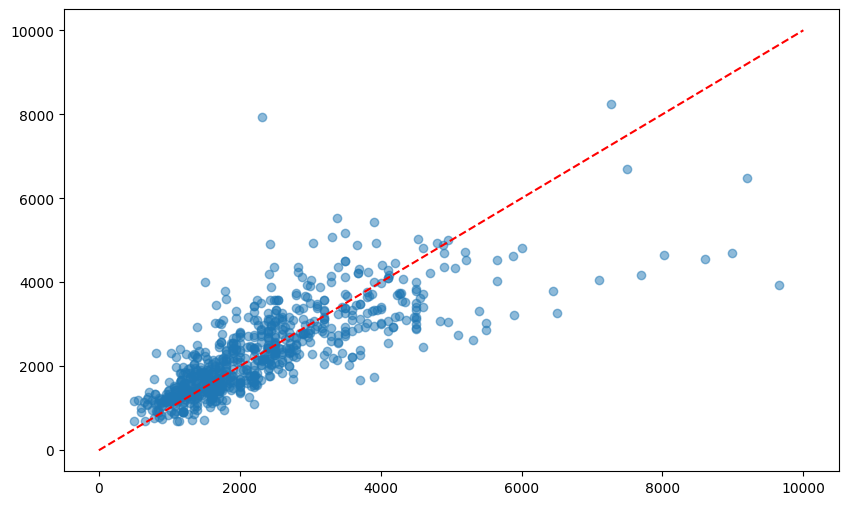

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([0, 10000], [0, 10000], color='red', linestyle='--')

plt.show()

* O modelo de Regressão Linear mostra  que os dados não se ajustam tão bem quanto poderiam. O *mean absolute error* mostra a distância média dos pontos de testes previstos pelo modelo em relação à linha vermelha, a qual demonstra o que aconteceria se o modelo acertasse 100% das previsões.

* Podemos realizar o mesmo processo para outro modelo de Regressão, por exemplo, a Árvore de Decisão por Regressão

In [ ]:
from sklearn import tree

reg_tree = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [ ]:
reg_tree.score(X_train, y_train)

0.9999982457122238

In [ ]:
y_pred_tree = reg_tree.predict(X_test)
mean_absolute_error(y_test, y_pred_tree)

675.9254742547425

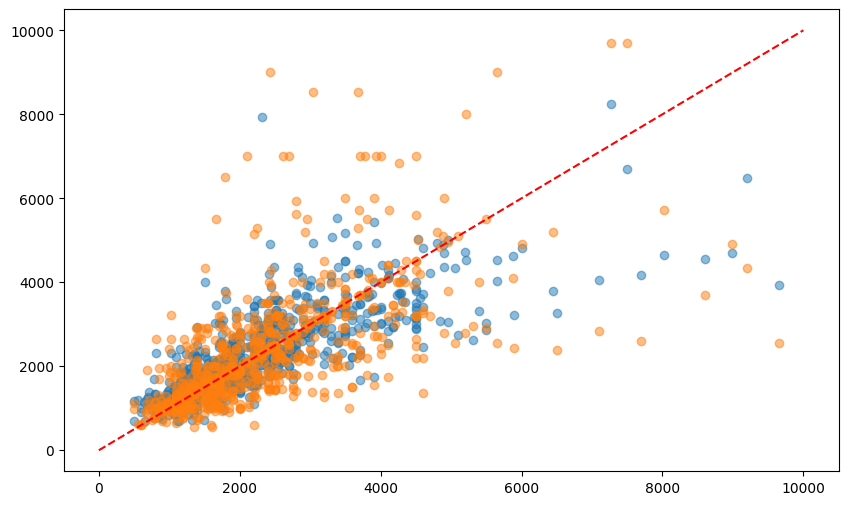

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, y_pred, alpha=0.5)
ax.scatter(y_test, y_pred_tree, alpha=0.5)
ax.plot([0, 10000], [0, 10000], color='red', linestyle='--')

plt.show()

* Uma análise com base nos erros nos mostra que, apesar da Árvore de Decisão por Regressão possuir um score alto, ela possui um erro muito maior do que o modelo de Regressão Linear. Portanto, ambos os modelos não estão caixando muito bem com nossos dados.

* Como melhorar os modelos?
    - Feature Selection é uma boa opção, isto é, encontrar mais relações de dependência entre o valor de aluguel (target) com as features

In [ ]:
colunas = base2.drop('aluguel', axis=1).columns
print(colunas)

Index(['condominio', 'iptu', 'metragem', 'quarto', 'banheiro', 'vaga_carro',
       'andar', 'aceita_pet', 'mobilia', 'metro_prox', 'Centro', 'Leste',
       'Norte', 'Oeste', 'Sul'],
      dtype='object')


In [ ]:
# Podemos percorrer toda a lista acima eliminando cada uma das colunas
nomes = ['todas']
regressao = [mean_absolute_error(y_test, y_pred)]
arvore = [mean_absolute_error(y_test, y_pred_tree)]

for i in colunas:
    nomes.append(i)
    base_nova = base2.drop(i,axis=1)

    # Definindo X e y
    X_novo = base_nova.drop('aluguel',axis=1)
    y_novo = base_nova.aluguel

    # Separando em treino e teste
    X_train_novo, X_test_novo, y_train_novo, y_test_novo = train_test_split(X_novo, y_novo, test_size=0.33, random_state=42)

    # Regressão Linear 
    reg = LinearRegression().fit(X_train_novo, y_train_novo)
    y_pred_novo = reg.predict(X_test_novo)
    regressao.append(mean_absolute_error(y_test_novo, y_pred_novo))

    # Árvore de regressão
    regArvore = reg_tree.fit(X_train_novo, y_train_novo)
    y_predArvore_novo = regArvore.predict(X_test_novo)
    arvore.append(mean_absolute_error(y_test_novo, y_predArvore_novo))
    
# Guardando o resultado em um DataFrame
resultado = pd.DataFrame([regressao,arvore])
resultado.columns = nomes

In [ ]:
resultado

,todas,condominio,iptu,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Centro,Leste,Norte,Oeste,Sul
0,538.196440,536.829189,542.782620,553.592480,539.594953,552.284223,547.388788,541.406259,539.125032,551.775677,538.366961,538.196440,538.196440,538.196440,538.196440,538.196440
1,675.925474,641.149051,660.253388,739.559169,690.854562,645.375339,698.046070,695.725384,684.624661,695.049910,691.788166,675.723126,688.168022,676.598916,683.014905,694.364047


* Retirando uma coluna por vez da base de dados não alterou praticamente nada o erro de previsão dos modelos.

* Outra possibilidade é alterar os parâmetros da árvore de decisão por regressão

In [ ]:
reg_tree2 = tree.DecisionTreeRegressor(random_state=42,criterion='poisson',max_depth=6)
reg_tree2 = reg_tree2.fit(X_train, y_train)
y_pred_tree2 = reg_tree2.predict(X_test)
mean_absolute_error(y_test, y_pred_tree2)

581.4684168353373

In [ ]:
# Percorrendo uma lista de parâmetros
depth = [2,3,4,5,6,7,8,9,10]
criterios = ['friedman_mse','absolute_error','poisson']
menor_valor = mean_absolute_error(y_test, y_pred_tree2)
menor_i = ''
menor_j = ''

for i in depth:
    for j in criterios:
        regArvore2 = tree.DecisionTreeRegressor(random_state=42,max_depth=i,criterion=j)
        regArvore2 = regArvore2.fit(X_train, y_train)
        y_predArvore2 = regArvore2.predict(X_test)
        valor = mean_absolute_error(y_test, y_predArvore2)
        if valor < menor_valor:
            menor_valor = valor
            menor_i = i
            menor_j = j
            menor_y_predArvore2 = y_predArvore2
        print(mean_absolute_error(y_test, y_predArvore2))
        
print(menor_i,menor_j,menor_valor)

670.785385063755
646.8252032520326
673.6729481216088
655.3251136495958
607.1165311653117
628.0861412225961
598.6517214658842
591.1409214092141
612.3663397901631
589.4597598915631
575.6415989159891
595.8459052086757
596.226135557458
574.8956639566395
581.4684168353373
610.6065021063165
573.6253387533875
609.9884139755541
631.9491127858429
580.2337398373984
600.5786419398305
629.503042223945
576.530487804878
616.5738892955238
631.3580629790811
592.5223577235772
627.5930581705497
7 absolute_error 573.6253387533875


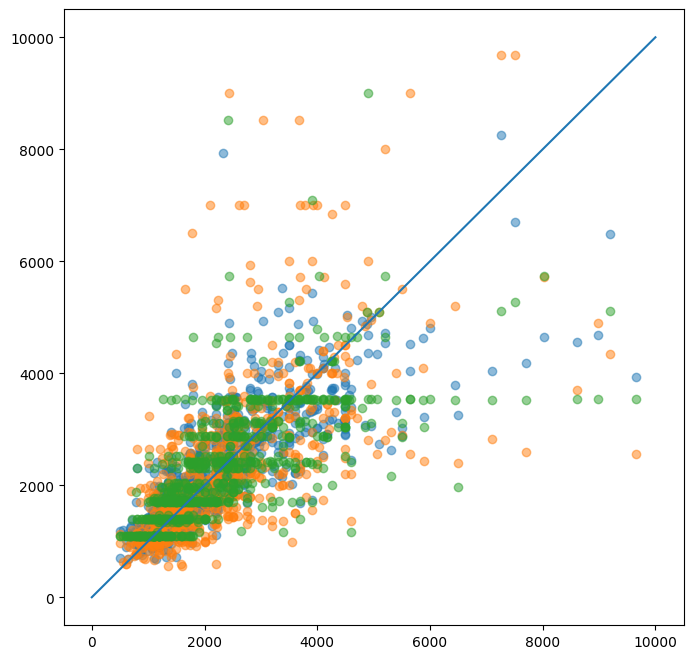

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(y_test, y_pred,alpha=0.5)
ax.scatter(y_test, y_pred_tree,alpha=0.5)
ax.scatter(y_test, y_pred_tree2,alpha=0.5)
ax.plot([0,10000],[0,10000])

plt.show()

* Podemos criar um novo algoritmo com um novo modelo de Regressão

In [ ]:
from sklearn.svm import SVR
reg_svr = SVR().fit(X_train, y_train)
y_pred_svr = reg_svr.predict(X_test)
mean_absolute_error(y_test, y_pred_svr)

852.1348418244451

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred_rf = reg_rf.predict(X_test)
mean_absolute_error(y_test, y_pred_rf)

492.04514776100143

<a id='producao'></a>
## Modelo em produção

In [ ]:
from joblib import dump

In [ ]:
dump(reg_rf, 'regressor.joblib')

['regressor.joblib']

In [ ]:
X_test.columns

Index(['condominio', 'iptu', 'metragem', 'quarto', 'banheiro', 'vaga_carro',
       'andar', 'aceita_pet', 'mobilia', 'metro_prox', 'Centro', 'Leste',
       'Norte', 'Oeste', 'Sul'],
      dtype='object')